In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
import os
os.chdir("../..")


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

from numpy.typing import NDArray
from typing import Callable


from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator


In [6]:
from qml.model.gate import Gateset
from qml.model.unit import Unit, UnitManager
from qml.model.encoding import EncodingUnit, EncodingUnitManager
from qml.model.model import Model
from qml.tools.dataset import Dataset
from qml.tools.dataloader import DataLoader
from qml.tools.typing import Vector
from qml.tools.logger import Logger
from qml.tools.random import XRandomGenerator

from qml.optimizer import evaluator as xeval


In [7]:
def deflatten(model, flattened_params):
    trainable_params = model.trainable_parameters
    tp_shapes = [len(tp) for tp in trainable_params]
    tp_shapes.insert(0, 0)
    tp_shape_idxs = np.cumsum(tp_shapes)
    return [
        flattened_params[idx_de:idx_to]
        for idx_de, idx_to
        in zip(tp_shape_idxs[:-1], tp_shape_idxs[1:])
    ]


In [62]:
nq = 2
ng = 3
nx = 1
ny = 1

# dataset
train_db_size = 10
validate_db_size = 10
test_db_size = 10
# loader
batch_size = 4


In [9]:
target_func = lambda x: np.sin(2 * x)
rng = XRandomGenerator()


In [10]:
xs = rng.uniform(-1, 1, train_db_size)
ys = target_func(xs)
dataset = Dataset(xs, ys)


In [11]:
uman = UnitManager(nq, ng)
model = Model(
    nq, ny,
    EncodingUnitManager.AngleEncoding(nx, nq, repeat=True),
    uman.generate_random_unit(),
    uman.generate_random_unit(),
)


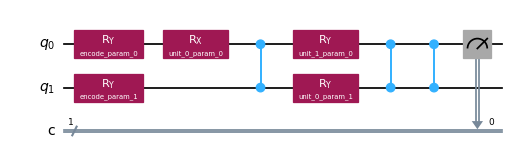

In [12]:
fig, ax = plt.subplots()
model.draw(ax=ax)


In [13]:
evaluator = xeval.MSEEvaluator(dataset, model, batch_size=batch_size)


In [14]:
params = model.trainable_parameters
params
fparams = np.hstack(params)
dparams = rng.normal(0, 1, size=fparams.shape)
new_params = fparams + dparams
new_params = model.deflatten(new_params)
res = evaluator(new_params)
res.loss


array(0.2792713)

In [15]:
tp = model.trainable_parameters
ftp = np.hstack(tp)
print("flatten:", ftp)

rtp = deflatten(model, flattened_params=ftp)
print("reconst:", rtp)


flatten: [0.0]
reconst: [array([0.0], dtype=object)]


### dev main loop

In [16]:
# prepare evaluator
evl = xeval.MSEEvaluator(dataset, model)


In [17]:
xc = np.hstack(model.trainable_parameters).astype(float)
ec = evl(params=model.deflatten(xc)).loss


In [18]:
log_ec = [ec]


In [19]:
print(xc, ec, len(log_ec))


[0.] 1.0814480156963213 1


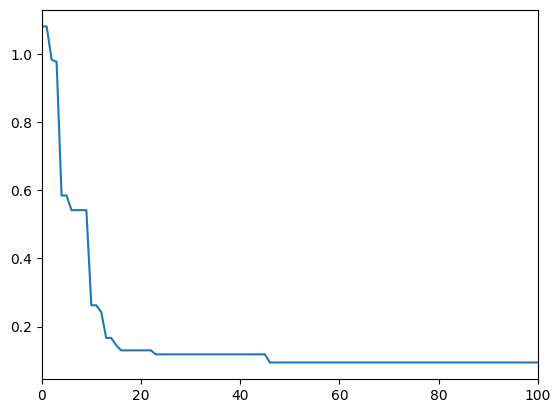

[-1.28542837] 0.094402006508463 101


In [20]:
for step in range(1, 100+1):
    xp = rng.normal(xc, 0.3, size=xc.shape)
    ep = evl(params=model.deflatten(xp)).loss
    
    if ep <= ec:
        xc = xp
        ec = ep
    
    log_ec.append(ec)

    if step % 5 == 0:
        clear_output()
        plt.cla()
        plt.plot(log_ec)
        plt.xlim(0, len(log_ec)-1)
        plt.show()

print(xc, ec, len(log_ec))


In [21]:
print(xc, ec, len(log_ec))


[-1.28542837] 0.094402006508463 101


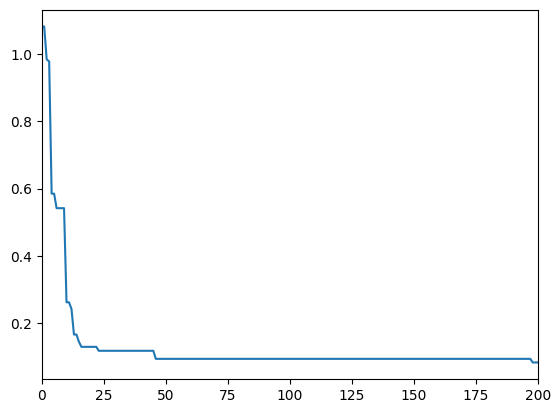

[-1.50330515] 0.08360610624705606 201


In [22]:
for step in range(1, 100+1):
    xp = rng.normal(xc, 0.3, size=xc.shape)
    ep = evl(params=model.deflatten(xp)).loss
    
    if ep <= ec:
        xc = xp
        ec = ep
    
    log_ec.append(ec)

    if step % 5 == 0:
        clear_output()
        plt.cla()
        plt.plot(log_ec)
        plt.xlim(0, len(log_ec)-1)
        plt.show()

print(xc, ec, len(log_ec))


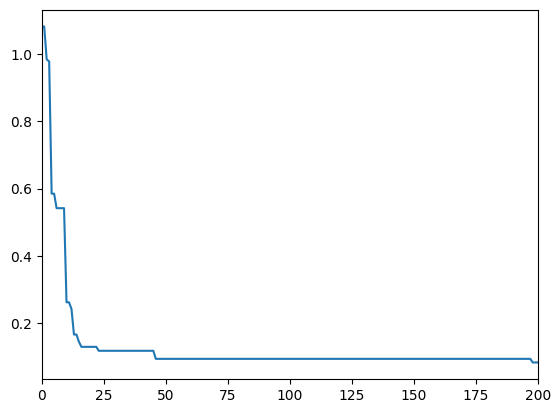

In [23]:
plt.plot(log_ec)
plt.xlim(0, len(log_ec)-1)
plt.show()


In [125]:
class Optimizer:

    MODE_PREFIX = dict(
        info="[info]",
    )
    EVALUATOR_CLASS = xeval.MSEEvaluator
    SHOW_INTERVAL = 100

    def __init__(
            self,
            train_dataset: Dataset,
            test_dataset: Dataset = None,
            test_interval: int = None,
            evaluator: xeval.Evaluator = None,
            shots: int = 50,
            seed: int = None
    ):
        self.rng = XRandomGenerator(seed)
        if test_dataset is None:
            test_dataset = train_dataset
        if evaluator is None:
            evaluator = self.EVALUATOR_CLASS

        self.train_dataset = train_dataset
        self.train_eval = None

        self.test_dataset = test_dataset
        self.test_eval = None
        self.test_interval = test_interval

        self.evaluator_class: xeval.Evaluator = evaluator
        self.shots = shots
        self.verbose = False
        self.logger: Logger = None
        self.show_interval = self.SHOW_INTERVAL

        self.last_r = None

        self.xb = None
        self.eb = None
    
    def initialize(self, model, batch_size):
        train_batch_size = len(self.train_dataset) if batch_size is None else batch_size
        test_batch_size = len(self.test_dataset) if batch_size is None else batch_size
        self.train_eval = self.evaluator_class(self.train_dataset, model, train_batch_size)
        self.test_eval = self.evaluator_class(self.test_dataset, model, test_batch_size)
        self.logger = Logger()
    
    def initial_candidate(self, model: Model):
        xc = np.asarray([
            unit for unit in model.trainable_parameters
        ]).astype(float)
        return xc

    def evaluate(self, params, test: bool = False) -> float:
        eval_func = self.train_eval if not test else self.test_eval
        return eval_func(params)
    
    def metrics(self, res) -> float:
        raise NotImplementedError()
    
    def log(self, step, xc, rc, xp=None, rp=None, test=False):
        if test:
            self.log_test(step, xc, rc)
            return
        # updata best solution
        if self.xb is None:
            self.xb = xc
            self.rb = rc
        elif self.metrics(rc) <= self.metrics(self.rb):
            self.xb = xc
            self.rb = rc
        if xp is None:
            xp = xc
            rp = rc
        self.logger.store(
            step, xp, xc, self.xb, self.metrics(rp), self.metrics(rc), self.metrics(self.rb)
        )
    
    def log_test(self, step, xt, rt):
        self.logger.store_test(
            step, xt, self.metrics(rt)
        )

    def optimize(
            self,
            model: Model,
            num_iter: int,
            batch_size: int = None,
            shots: int = None,
            test_interval: int = None,
            verbose: bool = False,
    ):
        if shots is not None:
            self.shots = shots
        self.test_interval = num_iter+1 if test_interval is None else test_interval

        self.initialize(model, batch_size)
        self.verbose = verbose

        xc = self.initial_candidate(model)
        rc = self.evaluate(xc)
        self.last_res = rc

        # initial logging
        self.log(0, xc, rc)
        if test_interval is not None:
            rt = self.evaluate(xc, test=True)
            self.log_test(0, xc, rt)

        for step in range(1, num_iter+1):
            xc, rc = self.optimize_once(step, xc, rc)

            if step % test_interval == 0:
                self.test_once(step)

            # if step % self.show_interval == 0:
            #     clear_output()
            #     self.logger.draw()

            self.last_res = rc
        
        return self.logger

    def optimize_once(self, step, xc, rc):
        xp = self.propose_candidate(xc)
        rp = self.evaluate(xp)

        xc, ec = self.update_candicate(step, xc, rc, xp, rp)
        self.log(step, xc, rc, xp, rp)

        return xc, ec
    
    def test_once(self, step, xc=None):
        xt = xc if xc is not None else self.xb
        rt = self.evaluate(xt, test=True)
        self.log_test(
            step, xt, rt
        )

    def propose_candidate(self, xc):
        raise NotImplementedError()

    def update_candicate(self, step, xc, rc, xp, rp):
        raise NotImplementedError()
    
    @classmethod
    def print(cls, values, mode="info", verbose=True):
        if verbose:
            values = str(values)
            if mode is not None:
                values = cls.MODE_PREFIX[mode] + " " + values
            print(values)
    
    @classmethod
    def info(cls, values, verbose=True):
        cls.print(values, mode="info", verbose=verbose)


In [126]:
class LocalSearchOptimizer(Optimizer):
    
    def __init__(
            self,
            train_dataset: Dataset,
            test_dataset: Dataset = None,
            test_interval: int = None,
            evaluator: xeval.Evaluator = None,
            shots: int = 50,
            div_candidate: float = 0.3,
    ):
        super().__init__(
            train_dataset,
            test_dataset,
            test_interval=test_interval,
            evaluator=evaluator,
            shots=shots,
        )
        self.sigma = div_candidate
    
    def propose_candidate(self, xc):
        xp = self.rng.normal(xc, self.sigma, size=xc.shape)
        return xp
    
    def update_candicate(self, step, xc, rc, xp, rp):
        ec = self.metrics(rc)
        ep = self.metrics(rp)
        if ep <= ec:
            return xp, rp
        return xc, rc
    
    def metrics(self, res):
        return res.loss


train_db_size = 30
test_db_size = 10
train_dataset = Dataset.generate_dataset(train_db_size, target_func)
test_dataset  = Dataset.generate_dataset(test_db_size,  target_func)

# fig, ax = plt.subplots()
# ax.scatter(train_dataset.xs, train_dataset.ys)
# ax.scatter( test_dataset.xs,  test_dataset.ys)

uman = UnitManager(nq, ng)
model = Model(
    nq, ny,
    EncodingUnitManager.AngleEncoding(nx, nq, repeat=True),
    [],
    # uman.generate_random_unit(),
    uman.generate_random_unit(),
)
optim = LocalSearchOptimizer(train_dataset, test_dataset)
log = optim.optimize(model, 100, test_interval=10)


KeyboardInterrupt: 

In [131]:
class MetropolisHastingsOptimizer(LocalSearchOptimizer):

    def __init__(
            self,
            train_dataset: Dataset,
            test_dataset: Dataset = None,
            test_interval: int = None,
            evaluator: xeval.Evaluator = None,
            shots: int = 50,
            div_candidate: float = 0.3,
            temperature: float = 1.0,
    ):
        super().__init__(
            train_dataset,
            test_dataset,
            test_interval=test_interval,
            evaluator=evaluator,
            shots=shots,
            div_candidate=div_candidate,
        )
        assert temperature > 0, f"temperature must be positive float, but {temperature} is given."
        self.temp = temperature
        self.beta = 1 / temperature
    
    def update_candicate(self, step, xc, rc, xp, rp):
        ec = self.metrics(rc)
        ep = self.metrics(rp)
        print(f"ec={ec:.3f} | ep={ep:.3f}", end="")
        if ec >= ep:
            print(" updated!")
            return xp, rp

        acceptance_ratio = self.potential(ep - ec)
        print(f" a={acceptance_ratio:.3f}", end="")
        if self.rng.random() <= acceptance_ratio:
            print(" accepted!")
            return xp, rp

        print("")
        return xc, rc
    
    def potential(self, rc: xeval.EvalResult | float):
        e = rc if isinstance(rc, float) else self.metrics(rc)
        return np.exp(-1. * e * self.beta)
    



train_db_size = 30
test_db_size = 10
train_dataset = Dataset.generate_dataset(train_db_size, target_func)
test_dataset  = Dataset.generate_dataset(test_db_size,  target_func)

# fig, ax = plt.subplots()
# ax.scatter(train_dataset.xs, train_dataset.ys)
# ax.scatter( test_dataset.xs,  test_dataset.ys)

uman = UnitManager(nq, ng)
model = Model(
    nq, ny,
    EncodingUnitManager.AngleEncoding(nx, nq, repeat=True),
    [],
    # uman.generate_random_unit(),
    uman.generate_random_unit(),
)
optim = MetropolisHastingsOptimizer(train_dataset, test_dataset, temperature=1/80)
optim.show_interval = 100
log = optim.optimize(model, 100, test_interval=10)


ec=0.916 | ep=1.036 a=0.000
ec=0.916 | ep=0.888 updated!
ec=0.888 | ep=0.823 updated!
ec=0.823 | ep=1.043 a=0.000
ec=0.823 | ep=0.935 a=0.000
ec=0.823 | ep=0.699 updated!
ec=0.699 | ep=0.599 updated!
ec=0.599 | ep=0.456 updated!
ec=0.456 | ep=0.258 updated!
ec=0.258 | ep=0.134 updated!
ec=0.134 | ep=0.155 a=0.182
ec=0.134 | ep=0.222 a=0.001
ec=0.134 | ep=0.181 a=0.022
ec=0.134 | ep=0.208 a=0.003
ec=0.134 | ep=0.458 a=0.000
ec=0.134 | ep=0.330 a=0.000
ec=0.134 | ep=0.177 a=0.032
ec=0.134 | ep=0.175 a=0.036
ec=0.134 | ep=0.382 a=0.000
ec=0.134 | ep=0.377 a=0.000
ec=0.134 | ep=0.183 a=0.019
ec=0.134 | ep=0.303 a=0.000
ec=0.134 | ep=0.237 a=0.000
ec=0.134 | ep=0.262 a=0.000
ec=0.134 | ep=0.241 a=0.000
ec=0.134 | ep=0.179 a=0.026
ec=0.134 | ep=0.219 a=0.001
ec=0.134 | ep=0.215 a=0.002
ec=0.134 | ep=0.165 a=0.079
ec=0.134 | ep=0.386 a=0.000
ec=0.134 | ep=0.176 a=0.034
ec=0.134 | ep=0.244 a=0.000
ec=0.134 | ep=0.157 a=0.155
ec=0.134 | ep=0.210 a=0.002
ec=0.134 | ep=0.390 a=0.000
ec=0.134 | ep

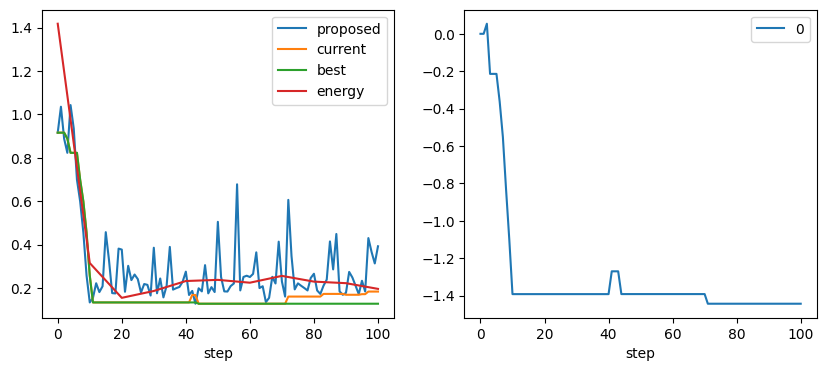

In [132]:
log.draw()


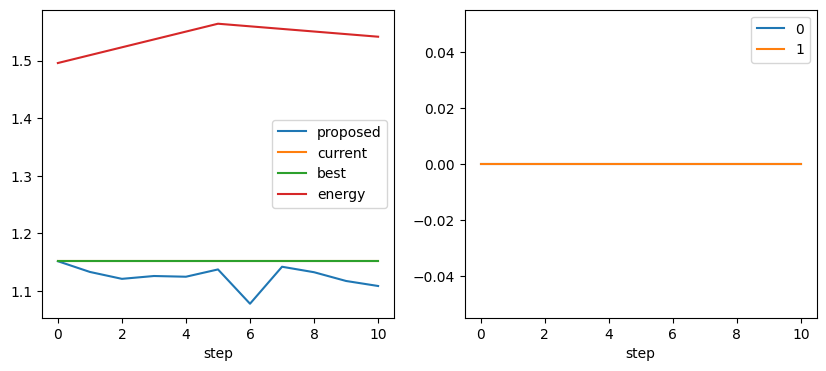

In [107]:
class StochsticGradientDicentOptimizer(Optimizer):

    EVALUATOR_CLASS = xeval.GradientEvaluator
    SHOW_INTERVAL = 1

    def __init__(
            self,
            train_dataset: Dataset,
            test_dataset: Dataset = None,
            test_interval: int = None,
            evaluator: xeval.Evaluator = None,
            shots: int = 50,
            lr: float = 0.1,
    ):
        super().__init__(
            train_dataset,
            test_dataset,
            test_interval=test_interval,
            evaluator=evaluator,
            shots=shots
        )
        self.lr = lr
    
    def propose_candidate(self, xc):
        rc = self.last_res
        dparams = rc.gradients * rc.errors.reshape((self.train_dataset.size, -1))
        xp = dparams.mean(axis=0) + dparams * self.lr
        return xp
    
    def update_candicate(self, step, xc, rc, xp, rp):
        return xc, rc
    
    def metrics(self, res) -> float:
        return res.loss


train_db_size = 30
test_db_size = 10
train_dataset = Dataset.generate_dataset(train_db_size, target_func)
test_dataset  = Dataset.generate_dataset(test_db_size,  target_func)

# fig, ax = plt.subplots()
# ax.scatter(train_dataset.xs, train_dataset.ys)
# ax.scatter( test_dataset.xs,  test_dataset.ys)

uman = UnitManager(nq, ng)
model = Model(
    nq, ny,
    EncodingUnitManager.AngleEncoding(nx, nq, repeat=True),
    [],
    # uman.generate_random_unit(),
    uman.generate_random_unit(),
)
optim = StochsticGradientDicentOptimizer(train_dataset, test_dataset)
log = optim.optimize(model, 10, test_interval=5)


In [102]:
evfunc = xeval.GradientEvaluator(train_dataset, model)
params = optim.initial_candidate(model)
res = evfunc(params)
dparams = res.grads * res.errors.reshape((optim.train_dataset.size, 1))
dparams = dparams.mean(axis=0)
print(dparams, params, params + dparams * optim.lr)


[-0.01366717 -0.00851969] [[0. 0.]] [[-0.00136672 -0.00085197]]


<Axes: xlabel='step'>

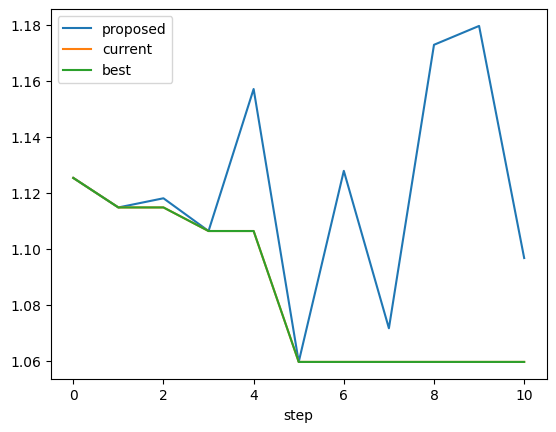

In [46]:
optim.logger.result_energies.plot(x="step")


(0.0, 6.283185307179586)

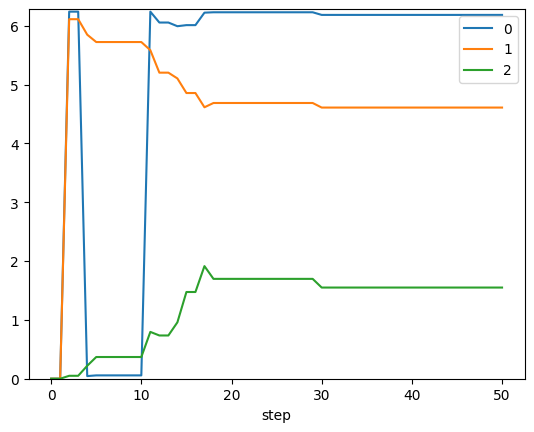

In [ ]:
res_xs = log.result_variable % (2 * np.pi)
res_xs.step = np.arange(len(res_xs))
res_xs.plot(x="step")
plt.ylim(0, np.pi*2)


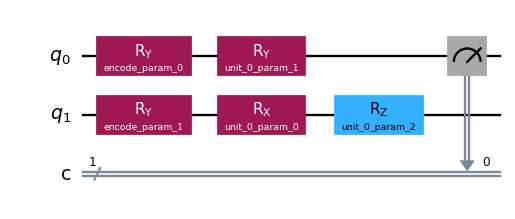

In [ ]:
fig, ax = plt.subplots()
model.draw(ax=ax)
plt.show()


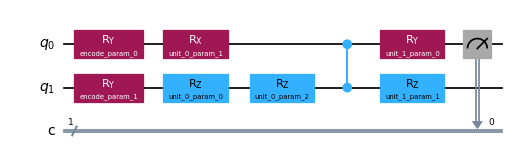

In [ ]:
fig, ax = plt.subplots()
model.draw(ax=ax)
plt.show()


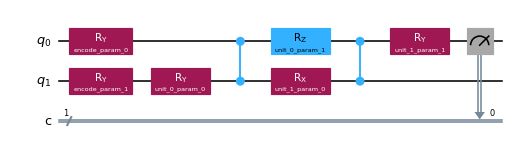

In [ ]:
fig, ax = plt.subplots()
model.draw(ax=ax)
plt.show()


In [32]:
! python --version


Python 3.12.7
